e:\Programs\Python\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
e:\Programs\Python\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Programs\Python\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Programs\Python\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sp

Epoch 1/50
7108/7108 [==============================] - 40s 5ms/step - loss: 0.8079 - val_loss: 0.7983
Epoch 2/50
7108/7108 [==============================] - 32s 4ms/step - loss: 0.7612 - val_loss: 0.7730
Epoch 3/50
7108/7108 [==============================] - 41s 6ms/step - loss: 0.7453 - val_loss: 0.7629
Epoch 4/50
7108/7108 [==============================] - 61s 9ms/step - loss: 0.7371 - val_loss: 0.7569
Epoch 5/50
7108/7108 [==============================] - 31s 4ms/step - loss: 0.7318 - val_loss: 0.7531
Epoch 6/50
7108/7108 [==============================] - 33s 5ms/step - loss: 0.7284 - val_loss: 0.7538
Epoch 7/50
7108/7108 [==============================] - 40s 6ms/step - loss: 0.7245 - val_loss: 0.7456
Epoch 8/50
7108/7108 [==============================] - 36s 5ms/step - loss: 0.7213 - val_loss: 0.7425
Epoch 9/50
7108/7108 [==============================] - 35s 5ms/step - loss: 0.7199 - val_loss: 0.7420
Epoch 10/50
7108/7108 [==============================] - 37s 5ms/step - l

e:\Programs\Python\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Programs\Python\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Programs\Python\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
e:\Programs\Python\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
e:\Progr

[[54103  2761]
 [   10    88]]


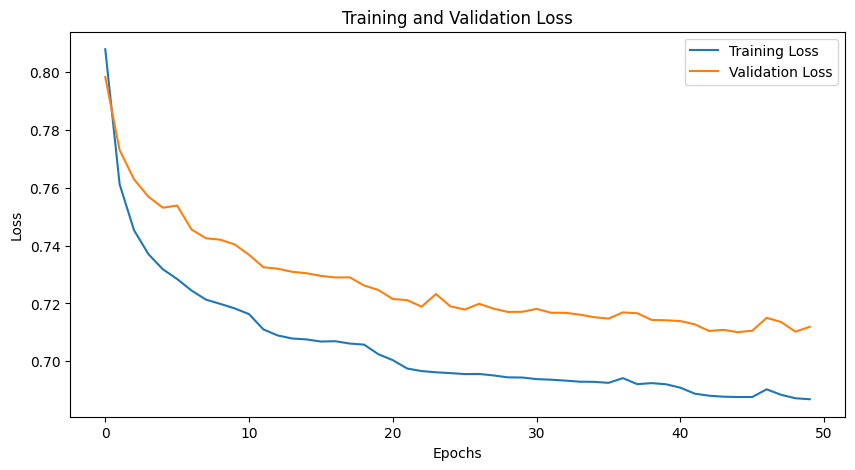

In [1]:
# a. Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# b. Upload / access the dataset
# Assuming the dataset is a CSV file named 'creditcard.csv'
data = pd.read_csv('creditcard.csv')

# Separate features and target variable
X = data.drop(columns=['Class'])  # Features
y = data['Class']                 # Target: 0 for normal, 1 for anomaly (fraud)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Use only non-fraud samples for training the autoencoder (for unsupervised anomaly detection)
X_train_non_fraud = X_train[y_train == 0]

# c. Encoder: Convert input into latent representation
input_dim = X_train_non_fraud.shape[1]
latent_dim = 14  # Dimension of the latent space (can be tuned)

# Define the encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation='relu')(input_layer)
encoder = Dense(16, activation='relu')(encoder)
encoder = Dense(latent_dim, activation='relu')(encoder)

# d. Decoder: Convert latent representation back to original input
decoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# e. Compile the model with optimizer, loss, and evaluation metrics
autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                    loss='mean_squared_error')

# Train the autoencoder
history = autoencoder.fit(X_train_non_fraud, X_train_non_fraud,
                          epochs=20,
                          batch_size=32,
                          validation_data=(X_test, X_test),
                          shuffle=True)

# f. Evaluate performance on test data and set threshold
# Get reconstruction error for test set
X_test_reconstructed = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)

# Set threshold for anomaly detection
threshold = np.percentile(mse, 95)  # 95th percentile

# Label predictions based on the threshold
y_pred = [1 if e > threshold else 0 for e in mse]

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()